🏆 Hacettepe AI Club 2024 Datathon Hikayem

Public LB: 206.53464 - Private LB: 238.05324 - 2024.04
Yarışma Sonucu: 3. Derece

💡 Yaklaşım - Approach
Bu yarışmada hiperparametre optimizasyonuna odaklanmak yerine, LSTM modelini kripto para piyasasının dinamiklerine uygun şekilde özelleştirmeyi tercih ettim. Coin verilerinin doğasını anlamak için zaman serisi özellikleri (günlük dalgalanmalar, haftanın günleri, teknik göstergeler) üzerinde derinlemesine çalıştım. Özellikle RSI, MACD ve Bollinger Bantları gibi teknik göstergeleri modele entegre ederek, finansal piyasa davranışlarını yakalamayı hedefledim.

Ayrıca, zaman bazlı özellik mühendisliği (örneğin, haftalık ortalamalar, geçmiş fiyat lagları) ile modelin tahmin gücünü artırdım. Hiperparametre optimizasyonu yapmadan, sadece bu özelliklerin doğru tasarımıyla MAE skorunda ciddi bir iyileşme sağladım.

📊 Sonuçlar - Results
Public LB (PV): 206.53464

Private LB (PB): 238.05324

Ortalama Mutlak Hata (MAE): ~200 birim

Bu skor, tahminlerimin gerçek değerlerden ortalama 200 birim sapmayla sonuçlandığını gösteriyor. Kripto para piyasasının yüksek volatilitesi düşünüldüğünde, bu sapma kabul edilebilir bir performans olarak değerlendirildi.

🎯 Çıkarımlar - Key Takeaways
Domain Bilgisi > Model Optimizasyonu:

Finansal verilerde başarı için, modelden önce piyasa dinamiklerini anlamak kritikti. Örneğin, "high-low" ilişkisi veya teknik göstergelerin anlamı gibi konular, modelin doğru özelliklerle beslenmesini sağladı.

LSTM'nin zaman serisi ilişkilerini yakalama yeteneği, bu projede anahtar rol oynadı.

Özellik Mühendisliği:

Zaman serisi verilerinde lag özellikleri (geçmiş 3-7 gün ortalamaları) ve teknik göstergeler, modelin tahmin kalitesini direkt olarak etkiledi.

"High ≥ Low" gibi finansal mantık kurallarını kayıp fonksiyonuna ekleyerek, modelin ilişkili sonuçlar üretmesini sağladım.

Basitlik ve Odak:

Hiperparametre optimizasyonu yapmadan, sadece veriye uygun özellikler ve LSTM'nin doğal avantajları ile 3. dereceyi elde ettim.

Zorluk:

Veri setlerinin büyüklüğü sebebiyle parametre optimizasyonu için vakit yeterliliği bulunmuyordu.

🛠️ Teknik Detaylar - Technical Details
Model Mimari:

4 katmanlı LSTM + Attention Mekanizması

Özel Kayıp Fonksiyonu: high ≥ low kuralını zorlayan ceza terimleri.

Öne Çıkan Özellikler:

Geçmiş 7 günün hareketli ortalaması

RSI (14 günlük periyot)

Haftanın günleri (Pazartesi etkisi)

Fiyatların logaritmik dönüşümü

🌟 Son Söz - Final Words
Bu yarışma bana, veri biliminde "doğru özelliklerin" model karmaşıklığından daha önemli olduğunu öğretti. Kripto para piyasası gibi dinamik bir alanda, LSTM'nin zaman serisi yeteneklerini doğru özelliklerle birleştirerek başarıya ulaştım.

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
import seaborn as sns

2025-03-10 13:43:05.910256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 13:43:05.910392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 13:43:06.060665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ----------------------- VERİLERİ SETLERİNİ HAZIRLAMA -----------------------

file_paths = [
    '/kaggle/input/aiclub-datathon/ail_frx.csv',
    '/kaggle/input/aiclub-datathon/bk_frx.csv',
    '/kaggle/input/aiclub-datathon/crp_ail.csv',
    '/kaggle/input/aiclub-datathon/zzc_ail.csv'
]

# Eksik değerleri doldurma fonksiyonu
def fill_missing_values(df):
    columns = ['date', 'open', 'high', 'low', 'close']
    
    for col in columns:
        # Veri setindeki tırnak işaretlerini kaldırıyoruz
        df[col] = df[col].astype(str).str.replace('"', '')
        # Eğer sütun 'date' ise, tam sayı olarak bırak, diğer sütunları float'a dönüştür
        if col == 'date':
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')  # Tam sayıya dönüştür
        else:
            df[col] = df[col].astype(float)
        
        # Eksik değerleri bir önceki ve bir sonraki değerin ortalaması ile doldur
        df[col] = df[col].interpolate(method='linear')
        
        # Eğer ilk hücre eksikse, bir sonraki değerle doldur
        df[col] = df[col].bfill()
        
        # Eğer son hücre eksikse, bir önceki değerle doldur
        df[col] = df[col].ffill()
    
    return df

# Her bir dosya için işlemi gerçekleştir
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df_filled = fill_missing_values(df)
    file_name = os.path.basename(file_path)
    output_name = file_name.replace('.csv', '_filled.xlsx')  # Yeni dosya adının sonuna _fillex.xlsx getir
    output_path = os.path.join('/kaggle/working/', output_name)
    
    # Doldurulmuş veriyi excel formatında kaydet
    df_filled.to_excel(output_path, index=False)
    
    print(f"{file_path} dosyası işlendi ve {output_path} konumlu dosya olarak kaydedildi.")

/kaggle/input/aiclub-datathon/ail_frx.csv dosyası işlendi ve /kaggle/working/ail_frx_filled.xlsx konumlu dosya olarak kaydedildi.
/kaggle/input/aiclub-datathon/bk_frx.csv dosyası işlendi ve /kaggle/working/bk_frx_filled.xlsx konumlu dosya olarak kaydedildi.
/kaggle/input/aiclub-datathon/crp_ail.csv dosyası işlendi ve /kaggle/working/crp_ail_filled.xlsx konumlu dosya olarak kaydedildi.
/kaggle/input/aiclub-datathon/zzc_ail.csv dosyası işlendi ve /kaggle/working/zzc_ail_filled.xlsx konumlu dosya olarak kaydedildi.


In [4]:
# ---------------------------- GENEL AYARLAR ----------------------------

COIN_SAYISI = 4  # İşlem yapılacak toplam coin sayısı
GRAFIK_BASLIK_PREFIX = "Coin Tahminleri"

# ------------------------ COIN KONFİGÜRASYONLARI ------------------------

    # "lookback" : Dinamik ayarlanabilir lookback değeri
    # "cross_validation_splits" : Dinamik ayarlanabilir çapraz doğrulama sayısı
    # Her bir değer 1 saatlik veriye denk gelmekte bu yüzden 72 saat gibi 3 günlük veri miktarı seçimi yaptım

COIN_CONFIG = [
    {
        "isim": "bk_frx",
        "dosya_yolu": "/kaggle/working/bk_frx_filled.xlsx",
        "tahmin_uzunlugu": 89,
        "lookback": 56,
        "cross_validation_splits": 7
    },
    {
        "isim": "crp_ail",
        "dosya_yolu": "/kaggle/working/crp_ail_filled.xlsx",
        "tahmin_uzunlugu": 201,
        "lookback": 72,
        "cross_validation_splits": 8
    },
    {
        "isim": "ail_frx",
        "dosya_yolu": "/kaggle/working/ail_frx_filled.xlsx", 
        "tahmin_uzunlugu": 201,
        "lookback": 72,
        "cross_validation_splits": 10
    },
    {
        "isim": "zzc_ail",
        "dosya_yolu": "/kaggle/working/zzc_ail_filled.xlsx",
        "tahmin_uzunlugu": 201,
        "lookback": 72,
        "cross_validation_splits": 10
    }
]

In [5]:
#------------------------------------------------------------
# ORTAK FONKSİYONLAR - 1 : VERİ SETİNİ ÖN İŞLEME VE HAZIRLAMA
#------------------------------------------------------------

#Veri setini yükleme ve önişleme
def load_and_preprocess_data(filepath):
    df = pd.read_excel(filepath)
    
    # 'date' sütunundaki tırnak işaretlerini kaldır ve sayısal formata dönüştür
    df['date'] = pd.to_numeric(df['date'], errors='coerce')  # Sayısal formata dönüştür, hatalı değerleri NaN yap
    
    # Milisaniyeyi cinsinden veriyi, tarih formatına dönüştürme
    df['date'] = pd.to_datetime(df['date'], unit='ms')
    
    # Tarihi saat, gün, ay, yıl gibi sayısal sütunlara ve haftanın gün bilgisini kategorik olarak ayırma
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Hour'] = df['date'].dt.hour
    df['Weekday'] = df['date'].dt.weekday  # Haftanın günleri 0: Pazartesi- 6: Pazar
    df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)  # Hafta sonu veya içi bilgisinin binary dönüşümü 
    
    # Mevsimsel özellikler
    def get_season(month):
        if month in [12, 1, 2]:
            return 0  #Kış
        elif month in [3, 4, 5]:
            return 1  #İlkbahar
        elif month in [6, 7, 8]:
            return 2  # Yaz
        elif month in [9, 10, 11]:
            return 3  #Sonbahar
    
    df['Season'] = df['Month'].apply(get_season)
    
    # Lag özellikleri ekleme
    for lag in [1, 2, 3, 5, 7]:  # 1, 2, 3, 5, 7 gün öncesinin değerlerini ekle
        df[f'open_lag_{lag}'] = df['open'].shift(lag)
        df[f'high_lag_{lag}'] = df['high'].shift(lag)
        df[f'low_lag_{lag}'] = df['low'].shift(lag)
        df[f'close_lag_{lag}'] = df['close'].shift(lag)
    # Lag özellikleri nedeniyle oluşan NaN değerleri temizle
    df = df.dropna()
    
    return df

#Teknik göstergeler ekleme
def add_technical_indicators(df):
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df['close'].ewm(span=12).mean()
    ema26 = df['close'].ewm(span=26).mean()
    df['MACD'] = ema12 - ema26
    df['Signal'] = df['MACD'].ewm(span=9).mean()
    
    # Bollinger Bantları
    ma20 = df['close'].rolling(20).mean()
    std20 = df['close'].rolling(20).std()
    df['UpperBB'] = ma20 + 2 * std20
    df['LowerBB'] = ma20 - 2 * std20
    
    return df.dropna()

# Veriyi model için hazırlama
def prepare_data(df, lookback, forecast_horizon):
    scaler = MinMaxScaler()
    
    features = df[['open', 'high', 'low', 'close', 
                   'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Is_Weekend', 'Season',
                   'open_lag_1', 'high_lag_1', 'low_lag_1', 'close_lag_1',
                   'open_lag_2', 'high_lag_2', 'low_lag_2', 'close_lag_2',
                   'open_lag_3', 'high_lag_3', 'low_lag_3', 'close_lag_3',
                   'open_lag_5', 'high_lag_5', 'low_lag_5', 'close_lag_5',
                   'open_lag_7', 'high_lag_7', 'low_lag_7', 'close_lag_7',
                   'RSI', 'MACD', 'Signal', 'UpperBB', 'LowerBB']]
    
    scaled_data = scaler.fit_transform(features)
    
    X, y = [], []
    for i in range(len(df) - lookback - forecast_horizon):
        X.append(scaled_data[i:i + lookback])
        y.append(scaled_data[i + lookback:i + lookback + forecast_horizon, :4])
        # Sadece open, high, low, close sütunlarını hedef olarak ayarlama
    #Ölçeklendirilmiş ve hazırlanmış veriyi geri döndür
    return np.array(X), np.array(y), scaler

In [6]:
#------------------------------------------------------
# ORTAK FONKSİYONLAR - 2 : LSTM MODEL MİMARİSİ TASARIMI
#------------------------------------------------------

# Özel kayıp fonksiyonumuz
def get_custom_loss(lambda_param=0.1):
    def custom_loss(y_true, y_pred):
        huber_loss = tf.keras.losses.Huber()(y_true, y_pred)
        
        # Sütun indeksleri
        high = y_pred[..., 1]
        low = y_pred[..., 2]
        open_ = y_pred[..., 0]
        close = y_pred[..., 3]
        
        # High >= Low durumu ihlali için ceza uygulama
        high_low_penalty = tf.reduce_mean(tf.square(tf.maximum(low - high + 1e-8, 0)))
        
        # Open ve Close için clamp cezaları uygulaması
        open_penalty = tf.reduce_mean(
            tf.square(tf.maximum(open_ - high, 0)) + 
            tf.square(tf.maximum(low - open_, 0)))
        
        close_penalty = tf.reduce_mean(
            tf.square(tf.maximum(close - high, 0)) + 
            tf.square(tf.maximum(low - close, 0)))

        #Amacımız 'high' sütununun 'low' sütunundan düşük olmamasını ve 4 sütununda mantıklı değerler içerisinde olmasını sağlamak
        total_penalty = high_low_penalty + open_penalty + close_penalty
        return huber_loss + lambda_param * total_penalty
    return custom_loss

class AttentionLayer(Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.units = units
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        # Attention skorları
        score = tf.nn.tanh(self.W1(inputs) + self.W2(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector

# Farklı boyutlarda katmanları olan bir LSTM modeli oluşturma ve dikkat mekanizması ekleme
def create_lstm_model_with_attention(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    
    # LSTM Katmanları
    lstm_out = LSTM(128, return_sequences=True)(inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = LSTM(64, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(64, return_sequences=True)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(32, return_sequences=True)(lstm_out)
    
    # Attention Layer (Diakkat Mekanizması)
    attention_out = AttentionLayer(32)(lstm_out)
    
    # Dense Katmanı
    # 4 çıkışı ayarlama: open, high, low, close
    dense_out = Dense(32, activation='relu')(attention_out)
    output = Dense(forecast_horizon * 4)(dense_out)
    output = Reshape((forecast_horizon, 4))(output)
    
    model = Model(inputs, output)
    model.compile(optimizer=Adam(0.001), loss=get_custom_loss(0.1), metrics=['mae'])
    return model

In [7]:
#----------------------------------------------------------------------------
# ORTAK FONKSİYONLAR - 3 : TAHMİNLERİ YÖNLENDİRME, GÖRSELLEŞTİRME VE KAYDETME
#----------------------------------------------------------------------------

# Tek sütun için kaydırma ve ölçeklendirme
def adjust_single_column(predicted_col, df, target_col, window=3):
    
    available_data = df[target_col].values
    window_size = min(window, len(available_data))
    avg_last = available_data[-window_size:].mean()
    return predicted_col + (avg_last - predicted_col[0])

# Vektörleştirilmiş işlemlerle tahmin ayarlamaları
def adjust_predictions(predictions, df, window=3):
    adjusted = predictions.copy()
    
    # Sütun bazlı ayarlamalar
    cols = ['open', 'high', 'low', 'close']
    for i, col in enumerate(cols):
        adjusted[:, i] = adjust_single_column(adjusted[:, i], df, col, window)
    
    # High-Low optimizasyonları
    high, low = adjusted[:, 1], adjusted[:, 2]
    swap_mask = low > high
    adjusted[swap_mask, 1], adjusted[swap_mask, 2] = low[swap_mask], high[swap_mask]
    
    # Sınır değer ayarlamaları
    adjusted[:, [0,3]] = np.clip(
        adjusted[:, [0,3]],
        adjusted[:, 2, np.newaxis],
        adjusted[:, 1, np.newaxis]
    )
    
    return adjusted

# Tahminleri grafik olarak terminalde çizmw ve aynı zamanda png dosya olarak kaydetme
def plot_results(df, predictions, steps, coin_name):
    plt.figure(figsize=(14, 7))
    
    # Veri hazırlığı : Son 500 veri ile birlikte görselleştirme
    data = df[['open', 'high', 'low', 'close']].values[-500:]
    t_actual = np.arange(len(data))
    t_forecast = t_actual[-1] + 1 + np.arange(len(predictions))
    
    # Grafik görünüş ayarları
    styles = {
        'colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
        'labels': ['Open', 'High', 'Low', 'Close'],
        'alpha': 0.7
    }
    
    for i in range(4):
        plt.plot(t_actual, data[:, i], 
                 color=styles['colors'][i],
                 label=f"Gerçek {styles['labels'][i]}",
                 alpha=styles['alpha'])
        
        plt.plot(t_forecast, predictions[:, i],
                 color=styles['colors'][i],
                 linestyle='--',
                 label=f"Tahmin {styles['labels'][i]}")
    
    plt.title(f"{GRAFIK_BASLIK_PREFIX} - {coin_name} ({steps} Adım Tahmin)")
    plt.xlabel("Zaman Adımları")
    plt.ylabel("Fiyat")
    plt.legend()
    plt.grid(True)
    
    output_file = f"/kaggle/working/{coin_name}_Tahmin_Grafigi.png"
    plt.savefig(output_file)
    print(f"Grafik dosyaya kaydedildi: {output_file}")
    
    plt.show()
    
    plt.close()

def save_predictions(predictions, coin_isim):
    df_pred = pd.DataFrame(predictions, 
                          columns=['Open_Tahmin', 'High_Tahmin', 'Low_Tahmin', 'Close_Tahmin'])
    output_file = f"/kaggle/working/{coin_isim}_Tahminler.xlsx"
    df_pred.to_excel(output_file, index=False)
    print(f"{coin_isim} tahminleri kaydedildi: {output_file}")


### ail_frx Veri Seti için EDA ###

**İlk 5 Satır:**
             date      open      high       low     close        RSI  \
19  1355418000000  6.599855  6.601472  6.597564  6.597564  65.612648   
20  1355421600000  6.598867  6.602191  6.591139  6.597429  69.601677   
21  1355598000000  6.597564  6.603314  6.590645  6.597294  68.510638   
22  1355601600000  6.597609  6.601472  6.591454  6.597159  48.464164   
23  1355605200000  6.596261  6.600574  6.592936  6.599945  55.718475   

        MACD    Signal   UpperBB   LowerBB  
19  0.001050  0.001130  6.605171  6.586385  
20  0.000897  0.001083  6.605201  6.587051  
21  0.000759  0.001018  6.605151  6.587784  
22  0.000634  0.000940  6.605015  6.588590  
23  0.000720  0.000896  6.605171  6.589261  

**Özet İstatistikler:**
               date          open          high           low         close  \
count  1.130300e+04  11303.000000  11303.000000  11303.000000  11303.000000   
mean   1.386440e+12      9.948466      9.957436      9.93768

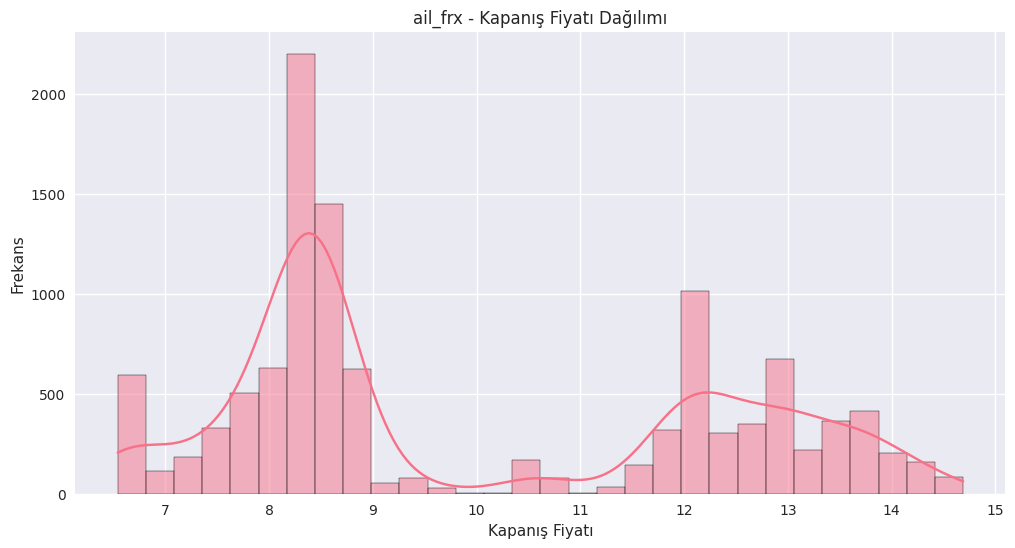

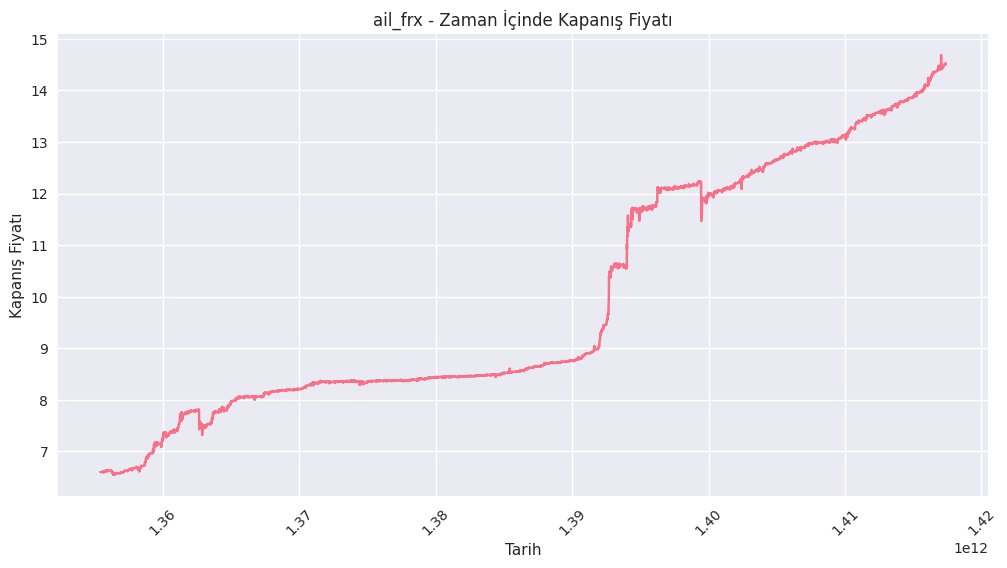

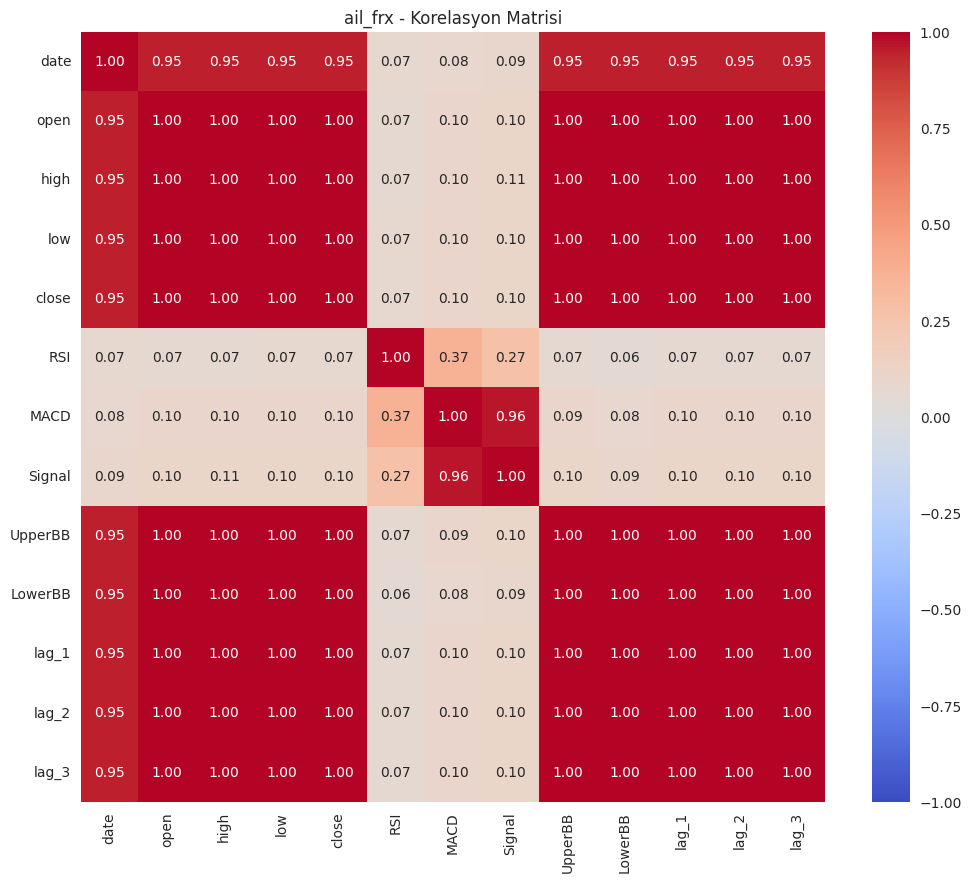

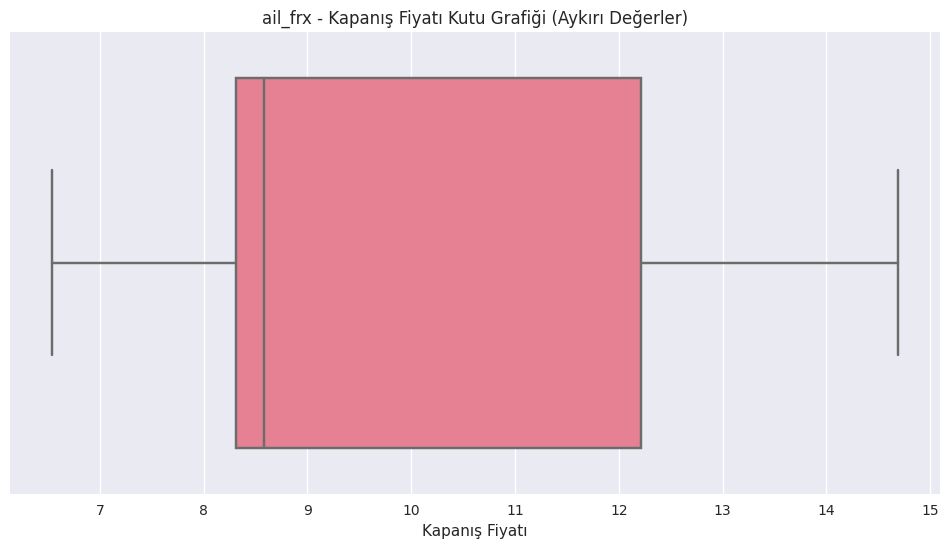

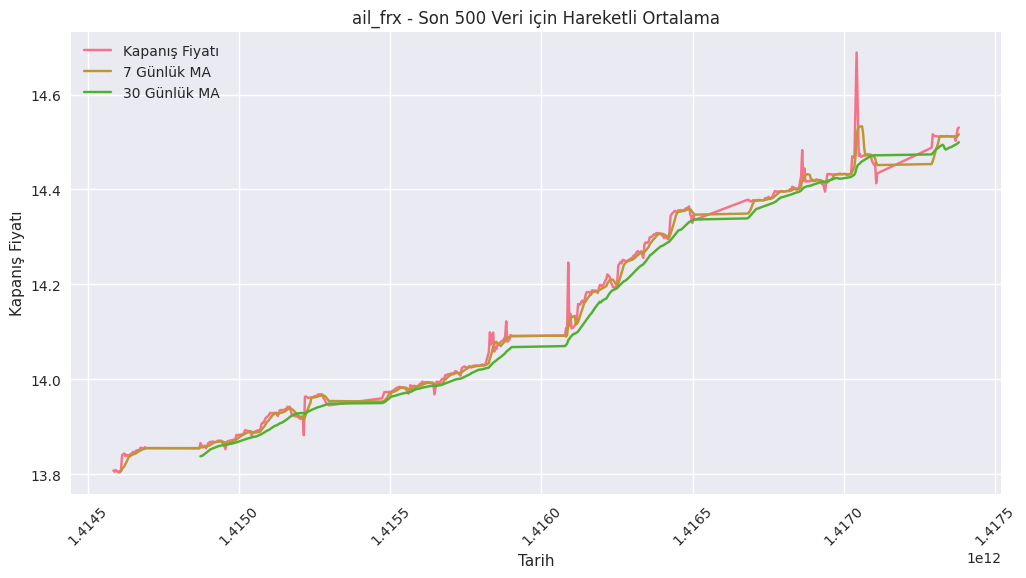

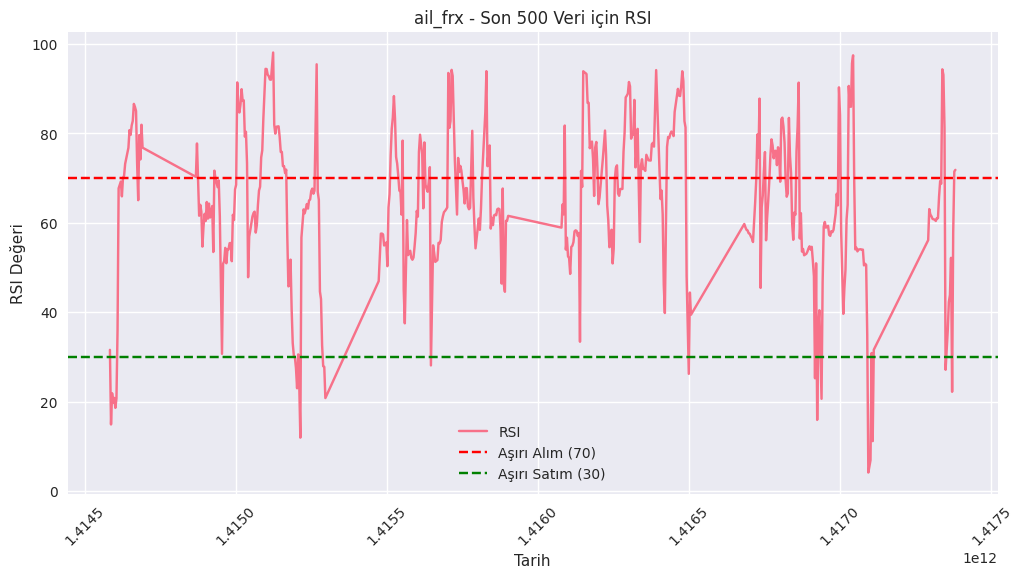

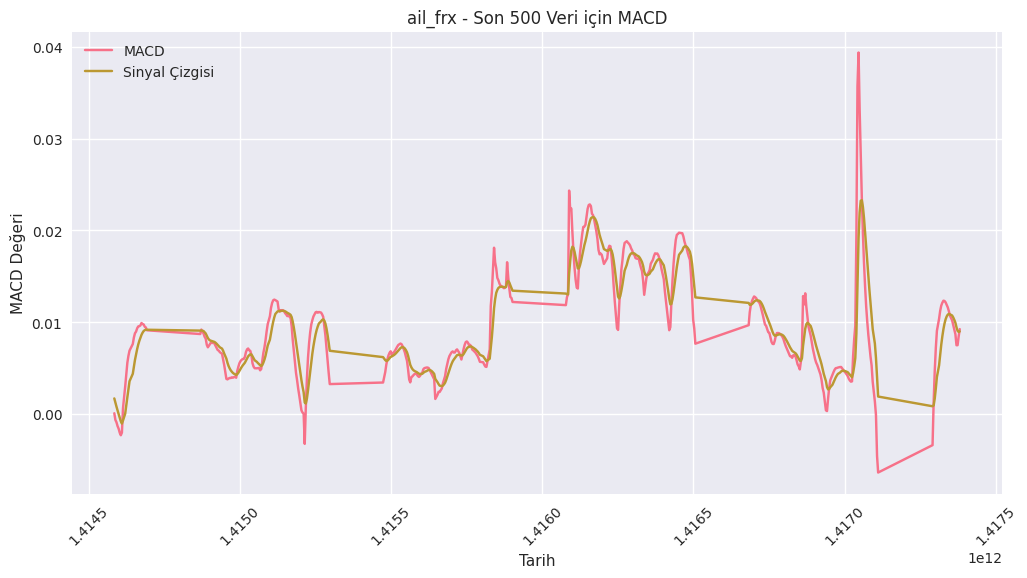

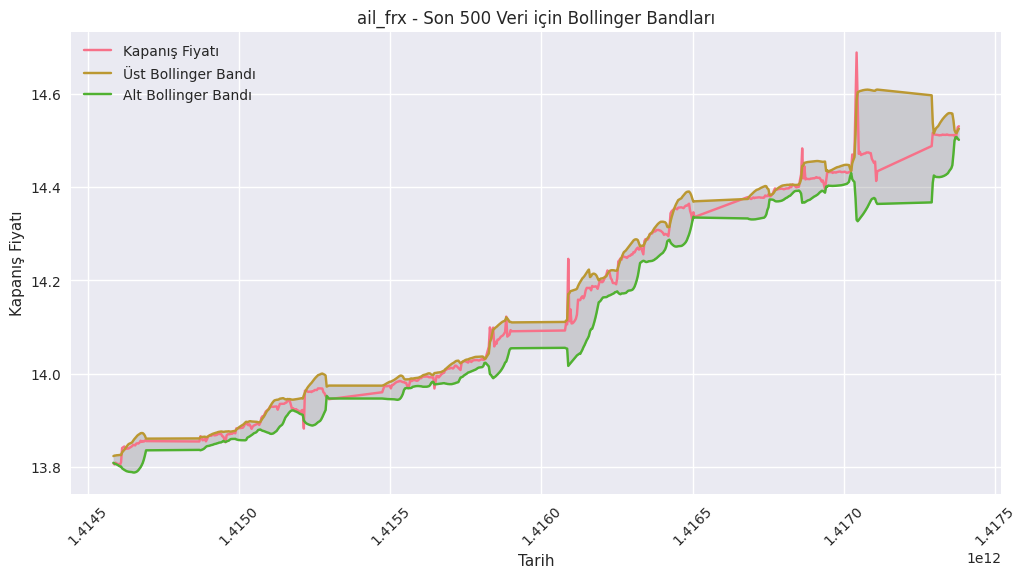


### bk_frx Veri Seti için EDA ###

**İlk 5 Satır:**
             date         open         high          low        close  \
19  1355662800000  5320.923478  5326.269565  5320.923478  5326.269565   
20  1355716800000  5340.280000  5349.796957  5325.624348  5349.796957   
21  1355720400000  5357.147826  5372.379565  5330.325217  5351.110435   
22  1355724000000  5351.986087  5369.199565  5350.442174  5368.485217   
23  1355727600000  5368.185652  5379.569130  5366.365217  5374.568696   

          RSI       MACD     Signal      UpperBB      LowerBB  
19  89.949405  22.155050  14.631921  5333.339710  5119.580681  
20  94.963759  25.329531  16.791360  5351.241312  5120.777514  
21  94.785871  27.573541  18.963826  5365.914513  5125.142835  
22  95.973394  30.167396  21.217846  5382.910916  5127.122737  
23  96.798144  32.244134  23.433567  5398.187559  5131.193398  

**Özet İstatistikler:**
               date          open          high           low         close  \
count  4.867000e+03 

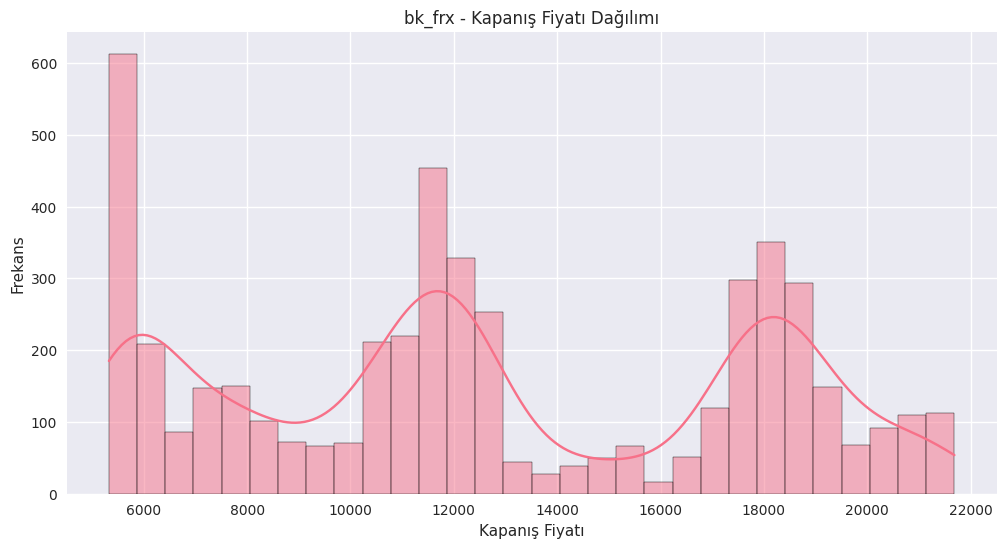

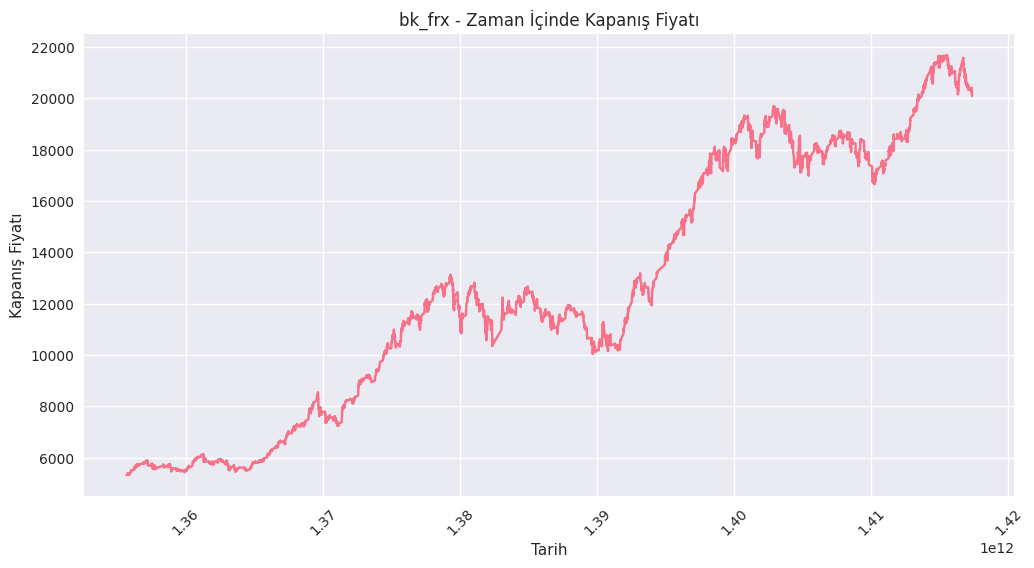

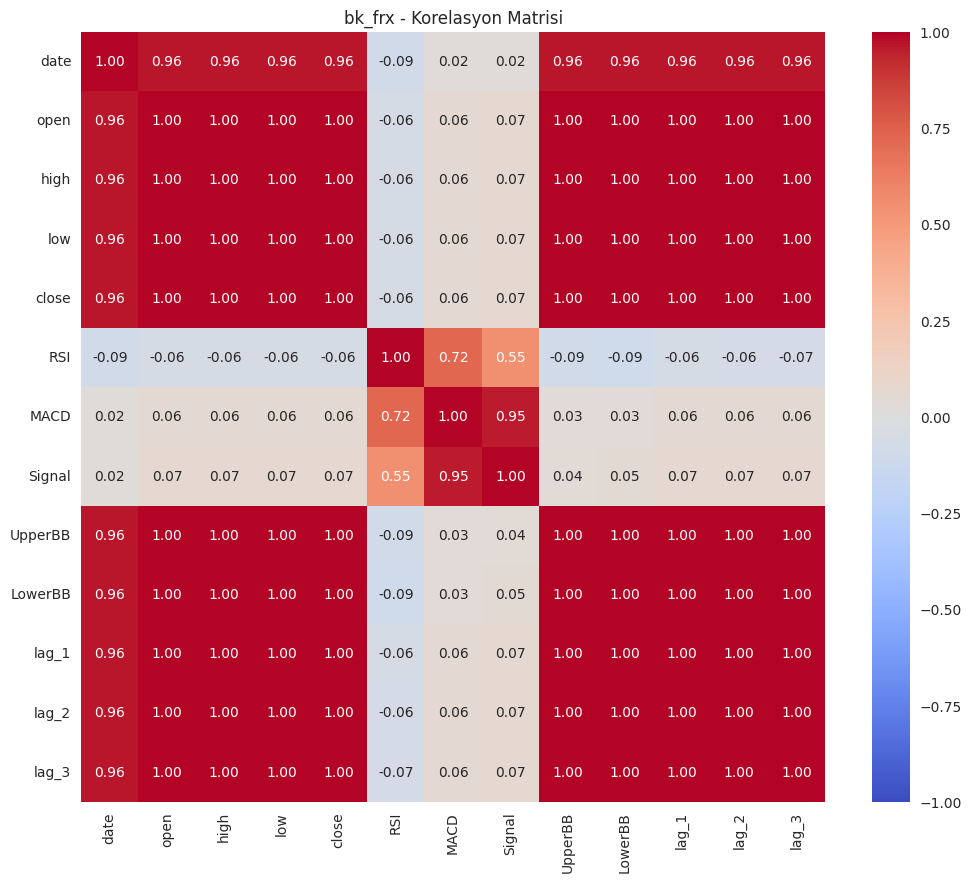

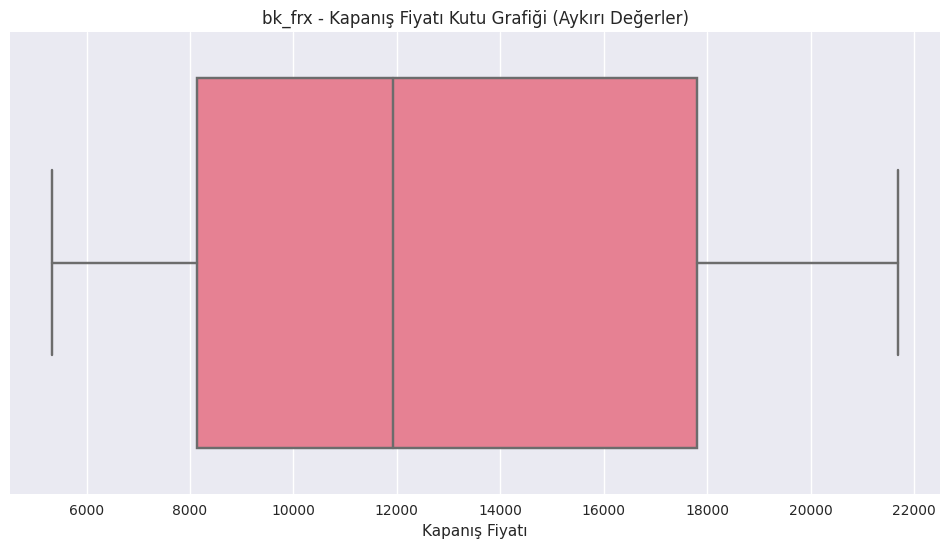

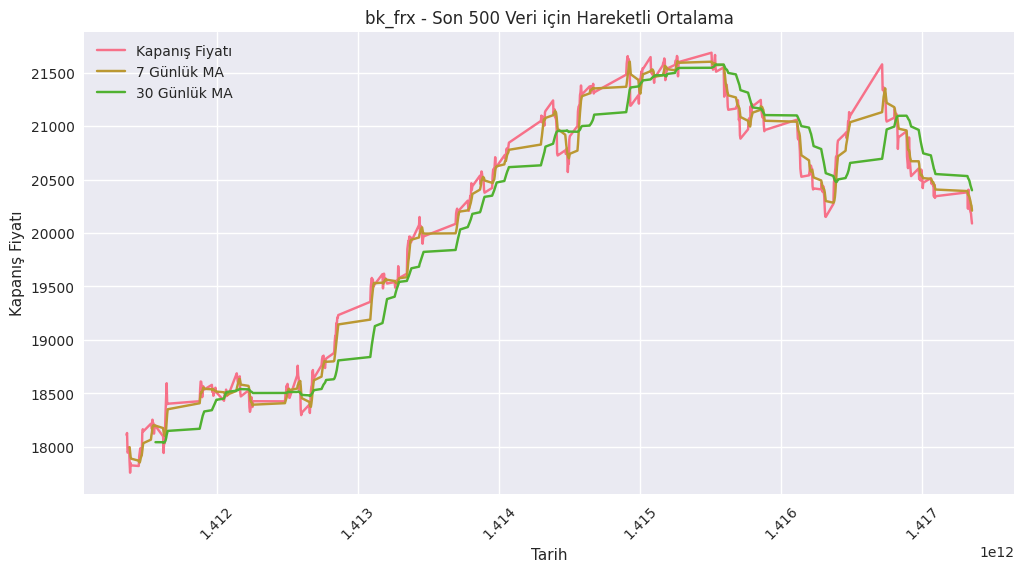

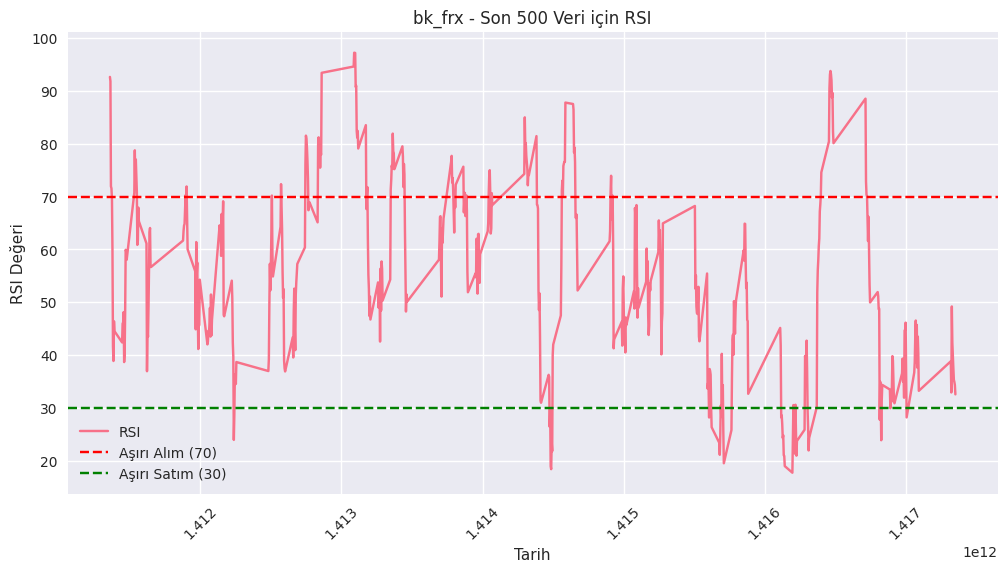

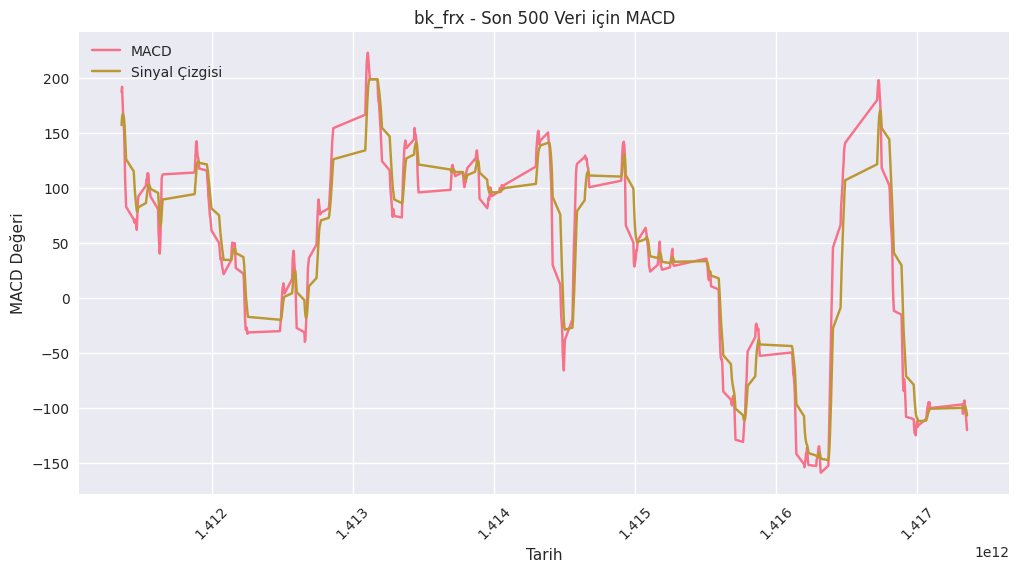

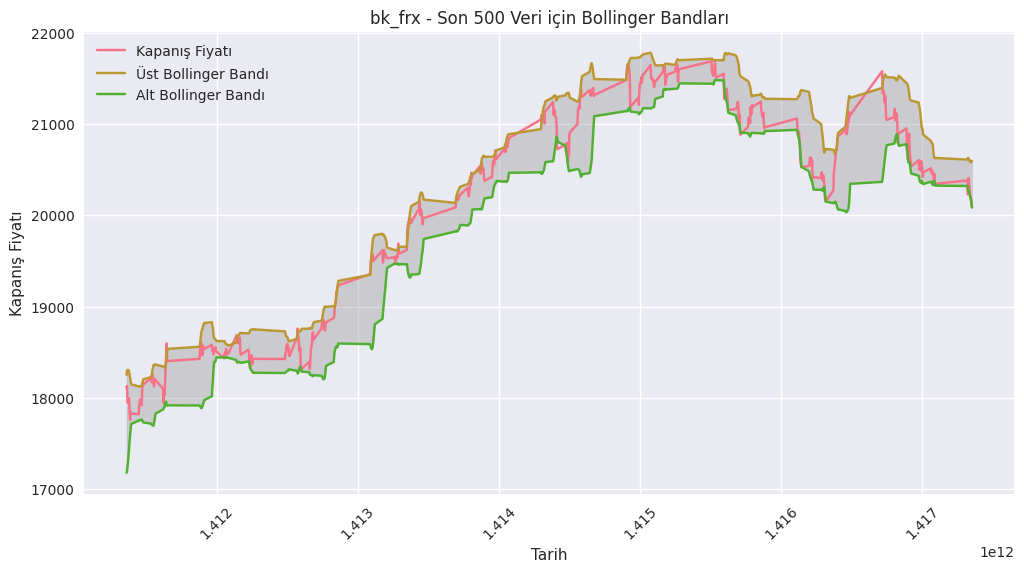


### crp_ail Veri Seti için EDA ###

**İlk 5 Satır:**
             date        open        high         low       close        RSI  \
19  1355414400000  274.617143  275.160000  274.587143  275.058571  38.531134   
20  1355418000000  275.061429  275.097143  274.435714  274.664286  29.440655   
21  1355421600000  274.727143  275.042857  274.620000  275.042857  34.827676   
22  1355598000000  275.038571  275.038571  275.024286  275.024286  39.240876   
23  1355601600000  275.005714  275.150000  274.500000  274.744286  38.933951   

        MACD    Signal     UpperBB     LowerBB  
19 -0.274761 -0.189314  277.371682  274.506603  
20 -0.297087 -0.211070  277.327319  274.345681  
21 -0.285440 -0.226054  277.259905  274.267095  
22 -0.274284 -0.235757  277.145962  274.215181  
23 -0.281631 -0.244976  277.087040  274.113531  

**Özet İstatistikler:**
               date          open          high           low         close  \
count  1.103600e+04  11036.000000  11036.000000  11036.000000  1103

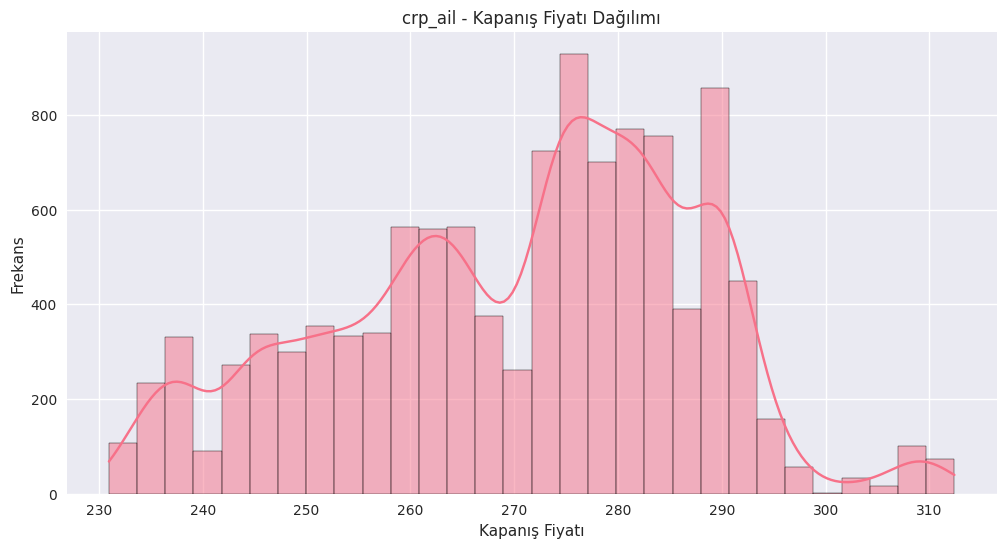

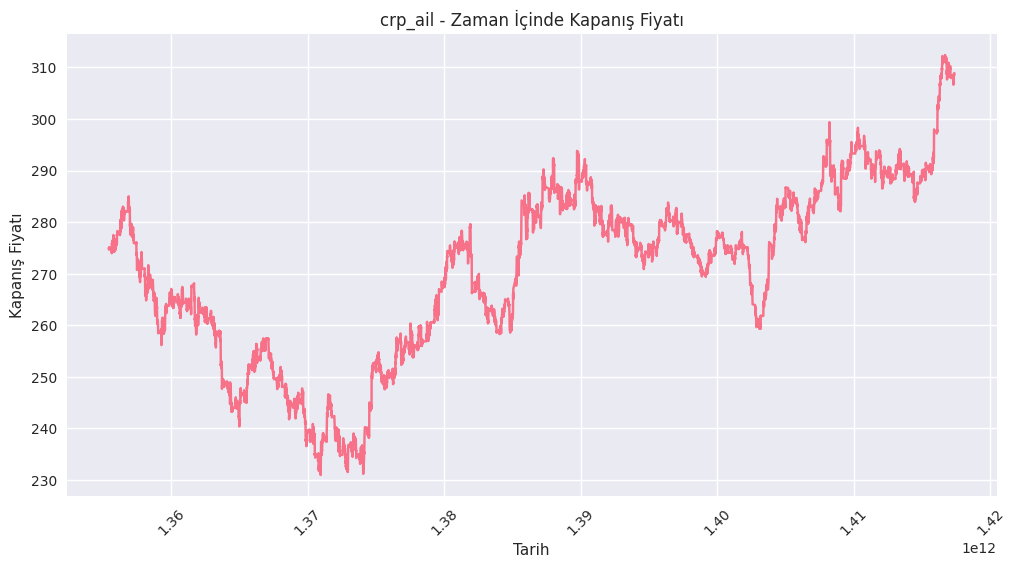

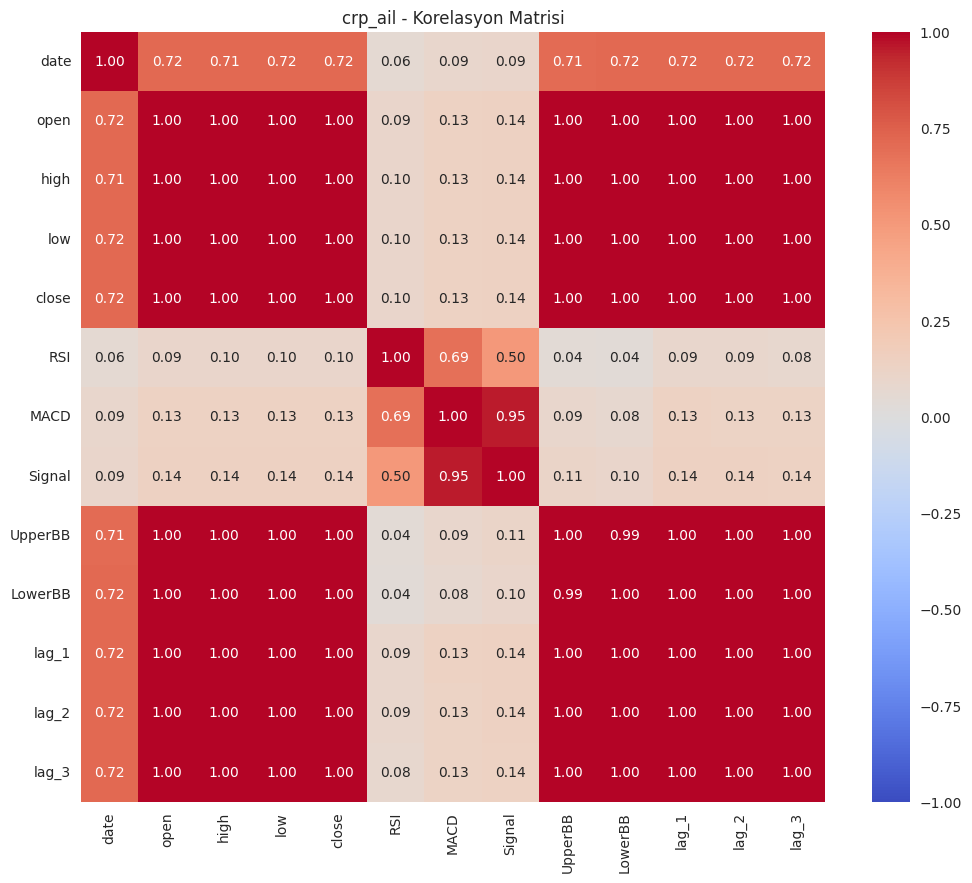

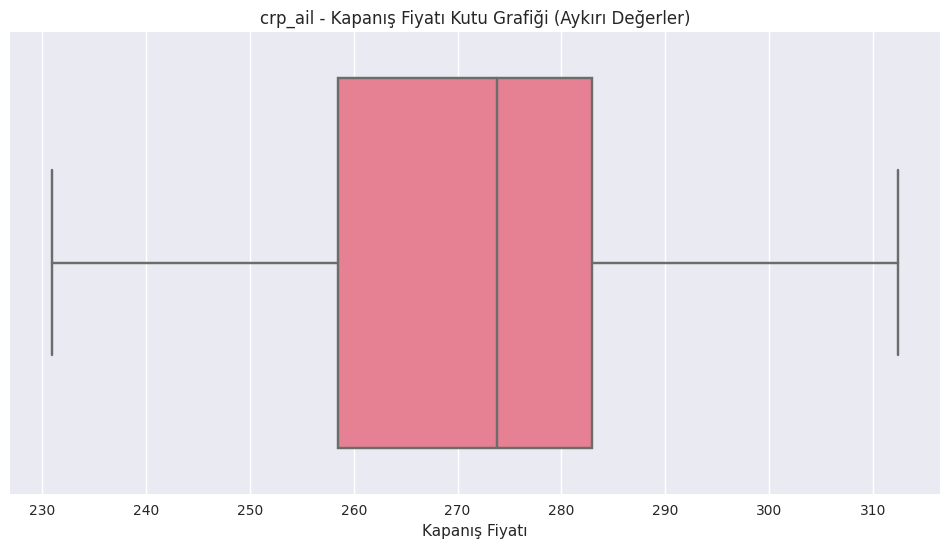

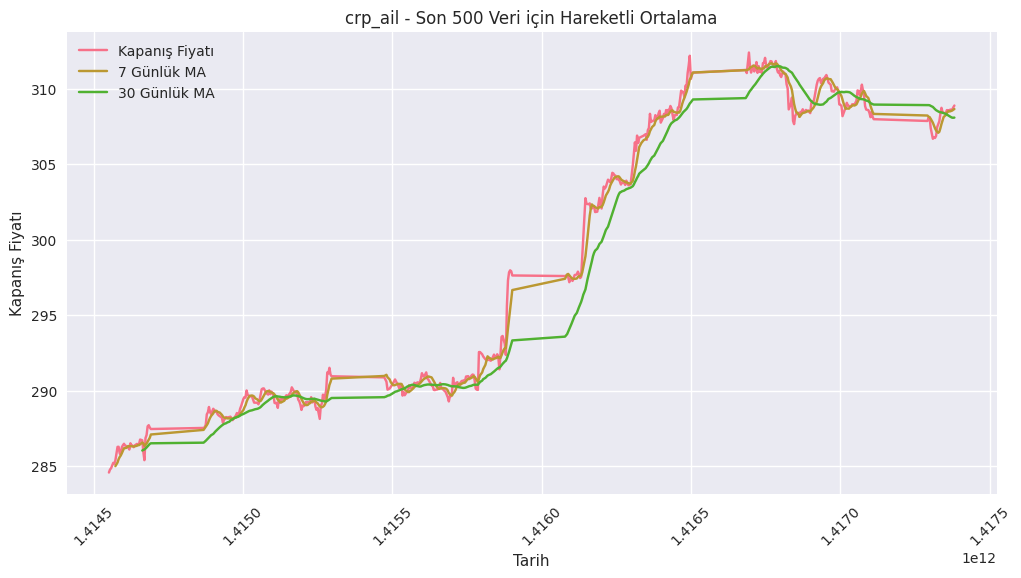

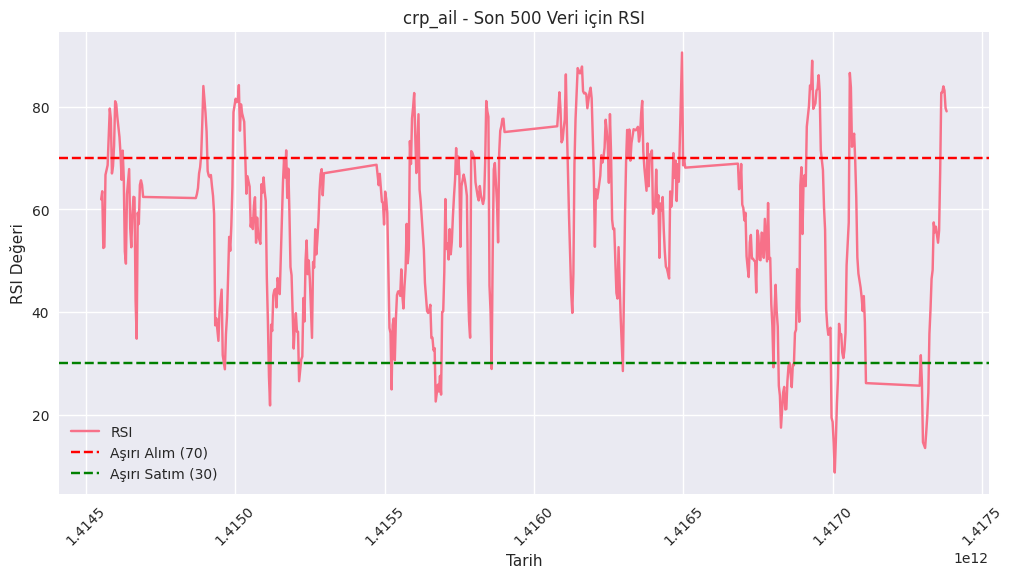

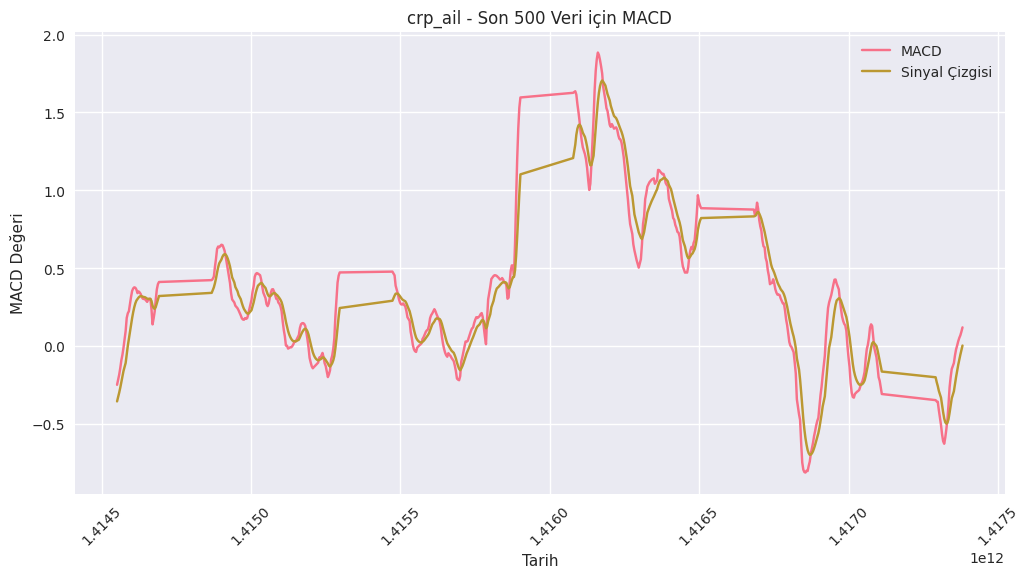

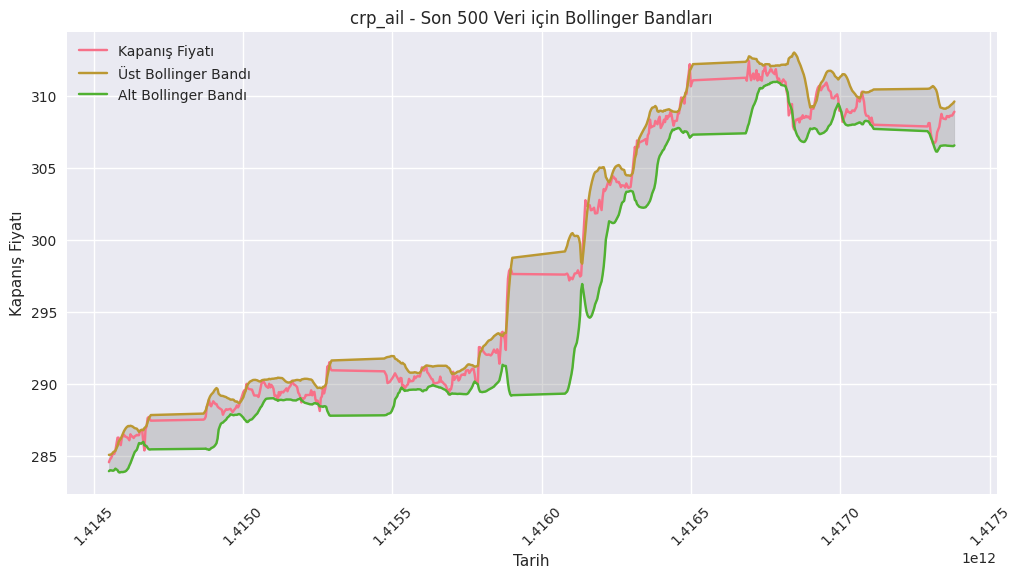


### zzc_ail Veri Seti için EDA ###

**İlk 5 Satır:**
             date          open          high           low         close  \
19  1355407200000  17536.262338  17542.664935  17339.288312  17339.288312   
20  1355410800000  17340.531169  17524.662338  17302.642857  17494.909091   
21  1355414400000  17493.816883  17533.964935  17422.032468  17476.567532   
22  1355418000000  17452.350649  17470.051948  17380.603896  17458.225974   
23  1355421600000  17454.422078  17467.792208  17362.337662  17380.038961   

          RSI       MACD     Signal       UpperBB       LowerBB  
19  71.451361  64.410472  20.795615  17472.800324  16652.345196  
20  78.972398  80.114544  32.769844  17523.709537  16627.573644  
21  77.396833  90.087926  44.318675  17564.172936  16609.816869  
22  76.138501  95.508660  54.617466  17603.329572  16596.605818  
23  70.250364  93.216401  62.373881  17630.059530  16593.075860  

**Özet İstatistikler:**
               date          open          high           low 

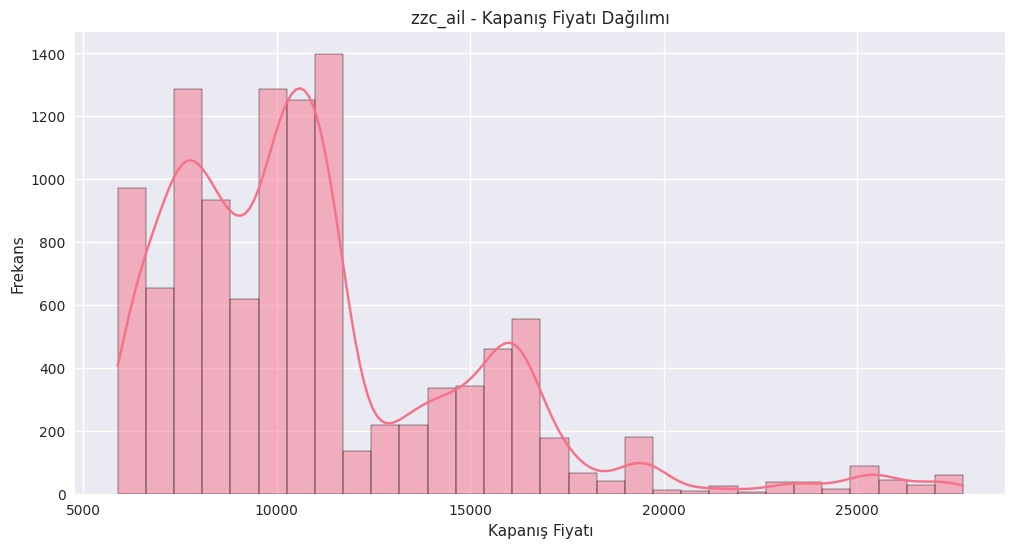

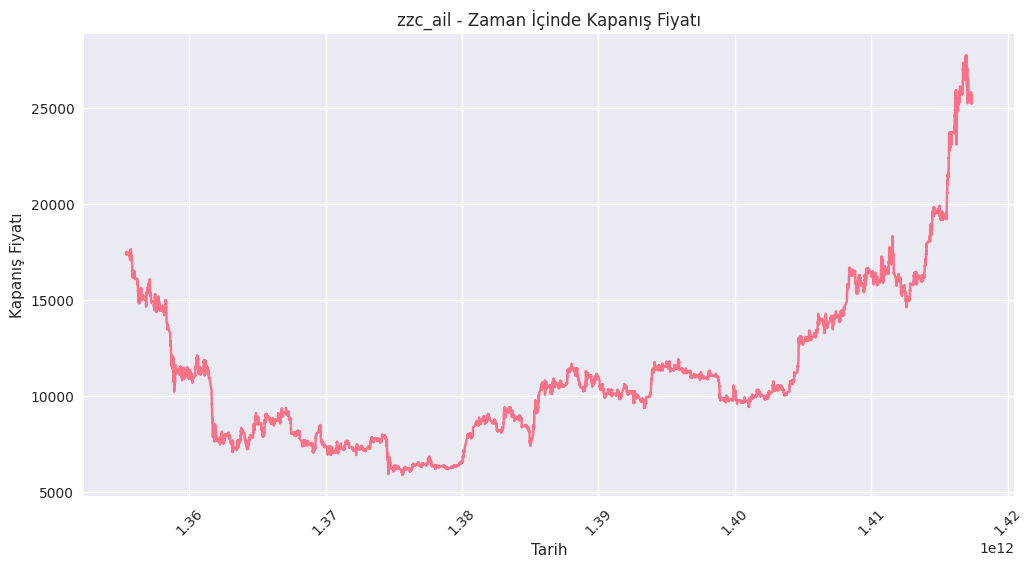

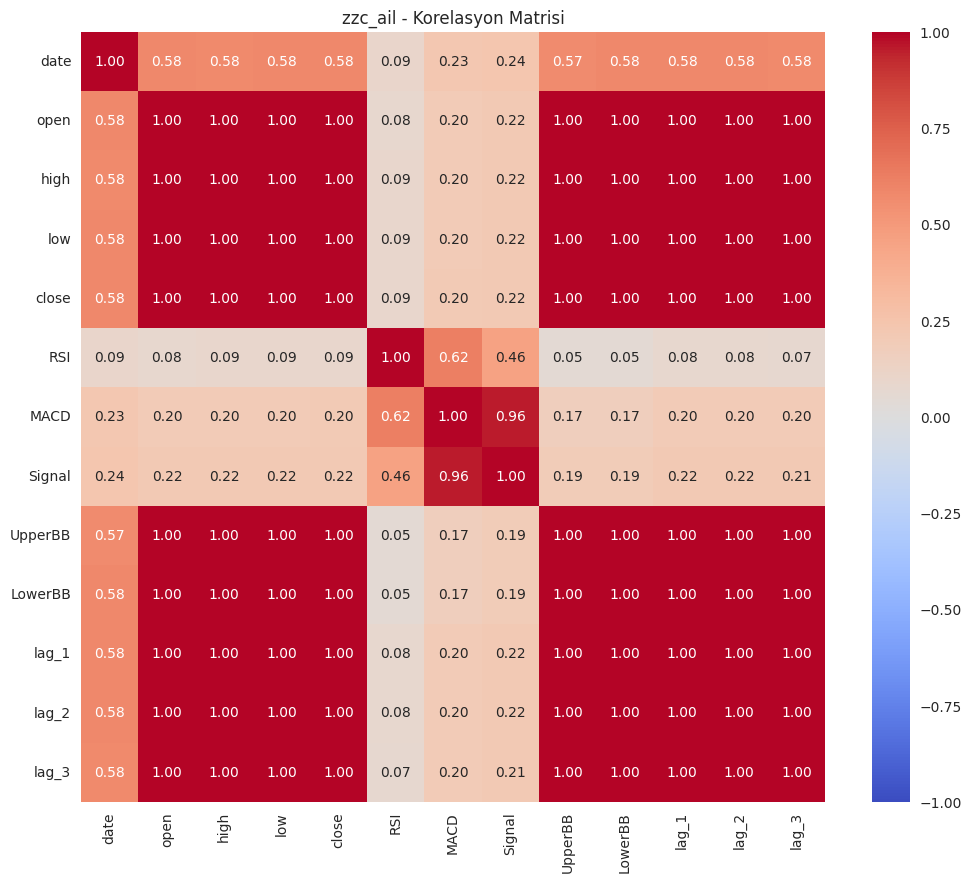

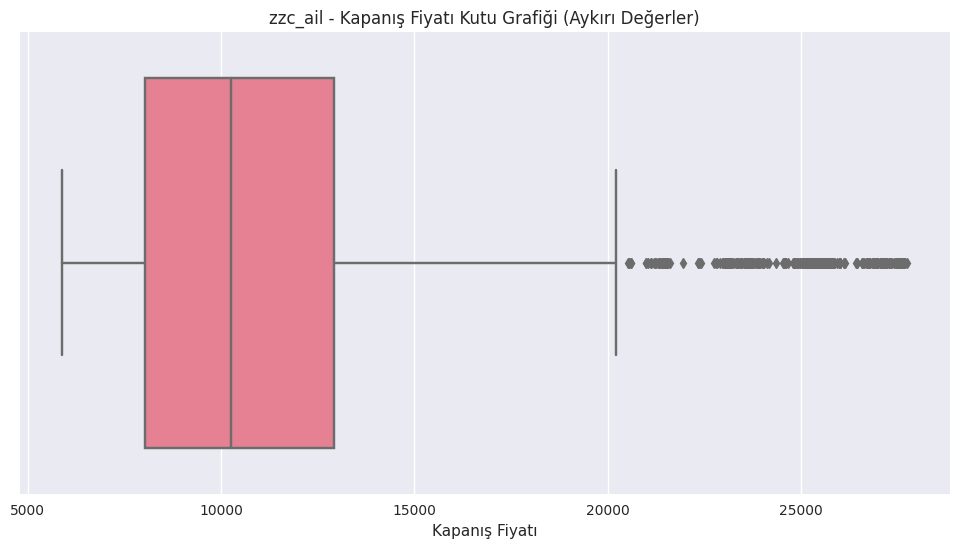

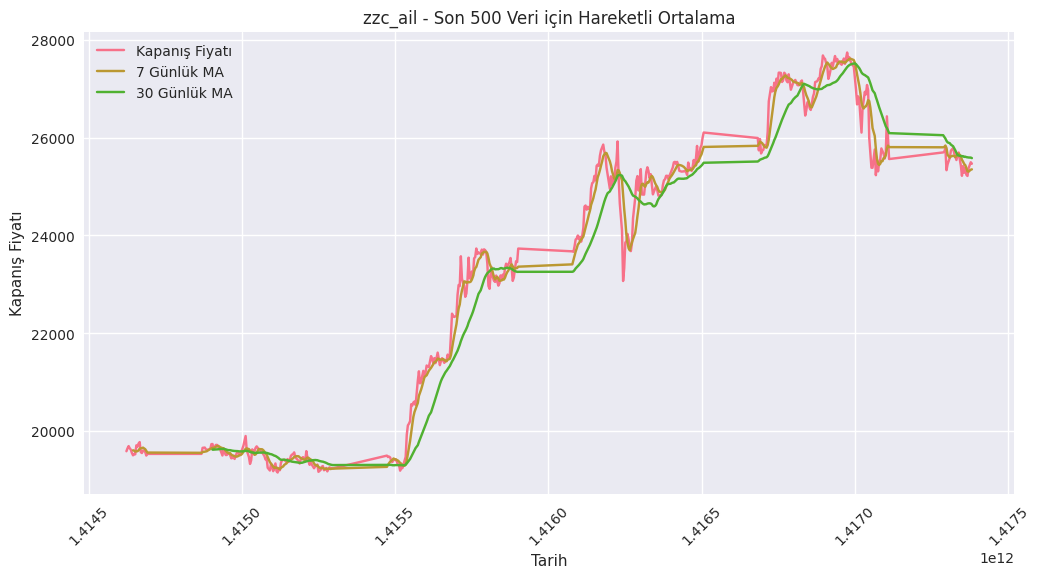

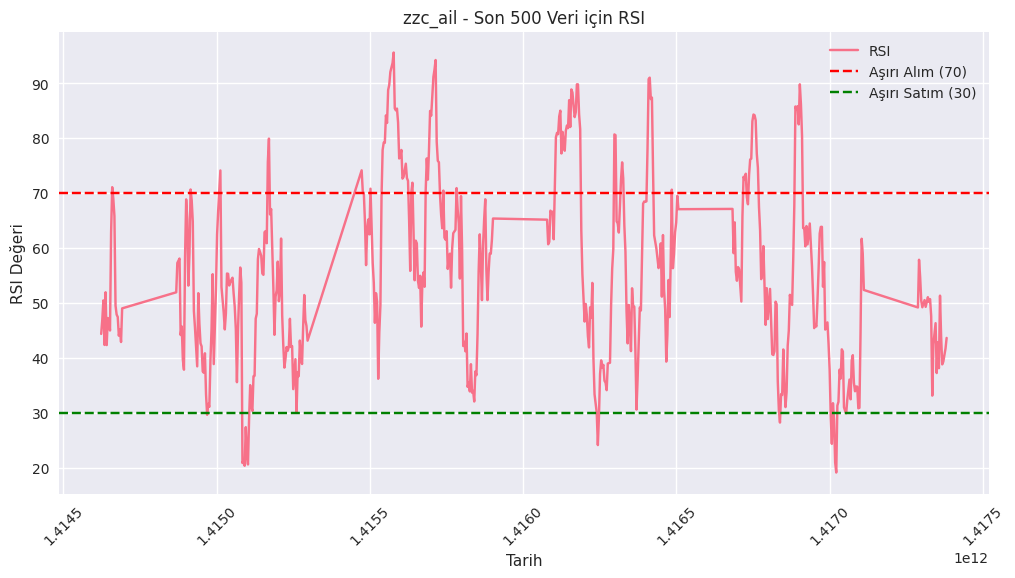

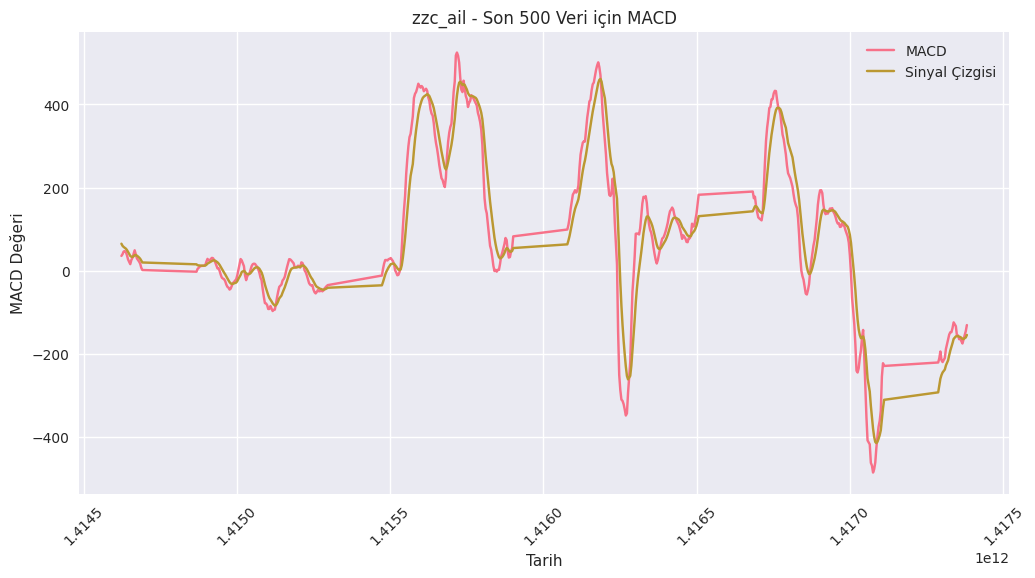

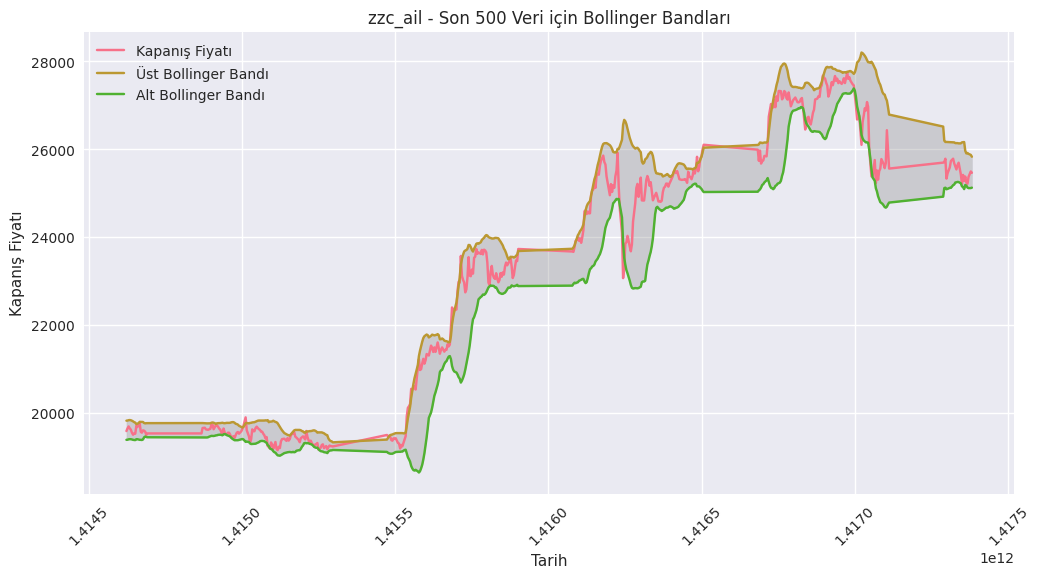


### Veri Setleri Arasında Genel Değerlendirme ###

ail_frx:
- Satır sayısı: 11303
- Tarih aralığı: 1355418000000 ile 1417381200000
- Ortalama kapanış fiyatı: 9.95
- RSI aralığı: 3.29 ile 100.00
- MACD aralığı: -0.19 ile 0.20

bk_frx:
- Satır sayısı: 4867
- Tarih aralığı: 1355662800000 ile 1417352400000
- Ortalama kapanış fiyatı: 12672.30
- RSI aralığı: 1.01 ile 99.93
- MACD aralığı: -281.86 ile 280.60

crp_ail:
- Satır sayısı: 11036
- Tarih aralığı: 1355414400000 ile 1417381200000
- Ortalama kapanış fiyatı: 270.17
- RSI aralığı: 0.00 ile 100.00
- MACD aralığı: -2.28 ile 2.35

zzc_ail:
- Satır sayısı: 11494
- Tarih aralığı: 1355407200000 ile 1417381200000
- Ortalama kapanış fiyatı: 11062.59
- RSI aralığı: 3.28 ile 99.15
- MACD aralığı: -563.74 ile 524.88



In [8]:
#------------------------------------------------------------
#---------------      VERİ GÖRSELLEŞTİRME      --------------
#------------------------------------------------------------

# Görselleştirme stilini ayarla
plt.style.use('seaborn')
sns.set_palette("husl")

# Önceden işlenmiş Excel dosyalarının yolları
excel_file_paths = [
    '/kaggle/working/ail_frx_filled.xlsx',
    '/kaggle/working/bk_frx_filled.xlsx',
    '/kaggle/working/crp_ail_filled.xlsx',
    '/kaggle/working/zzc_ail_filled.xlsx'
]

# Lag özelliklerini ekleyen fonksiyon
def add_lag_features(df, lags=[1, 2, 3]):
    for lag in lags:
        df[f'lag_{lag}'] = df['close'].shift(lag)
    return df.dropna()

# Keşifsel Veri Analizi (EDA) Fonksiyonu
def perform_eda(dataframes):
    for name, df in dataframes.items():
        
        print(f"\n### {name} Veri Seti için EDA ###\n")
        
        # Temel Bilgiler
        print("**İlk 5 Satır:**")
        print(df.head())
        print("\n**Özet İstatistikler:**")
        print(df.describe())
        
        # Dağılım Analizi
        plt.figure(figsize=(12, 6))
        sns.histplot(df['close'], kde=True, bins=30)
        plt.title(f'{name} - Kapanış Fiyatı Dağılımı')
        plt.xlabel('Kapanış Fiyatı')
        plt.ylabel('Frekans')
        plt.show()
        
        # Zaman Serisi Analizi
        plt.figure(figsize=(12, 6))
        plt.plot(df['date'], df['close'], label='Kapanış Fiyatı')
        plt.title(f'{name} - Zaman İçinde Kapanış Fiyatı')
        plt.xlabel('Tarih')
        plt.ylabel('Kapanış Fiyatı')
        plt.xticks(rotation=45)
        plt.show()
        
        # Lag özelliklerini ekle
        df = add_lag_features(df)
        
        # Korelasyon Matrisi (Lag özellikleri dahil)
        plt.figure(figsize=(12, 10))
        numeric_df = df.select_dtypes(include=[np.number])
        corr = numeric_df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
        plt.title(f'{name} - Korelasyon Matrisi')
        plt.show()
        
        # Aykırı Değer Analizi
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=df['close'])
        plt.title(f'{name} - Kapanış Fiyatı Kutu Grafiği (Aykırı Değerler)')
        plt.xlabel('Kapanış Fiyatı')
        plt.show()
        
        # Son 500 veri için teknik göstergeler
        df_last_500 = df.tail(500)
        
        # Hareketli Ortalama Grafiği
        plt.figure(figsize=(12, 6))
        plt.plot(df_last_500['date'], df_last_500['close'], label='Kapanış Fiyatı')
        plt.plot(df_last_500['date'], df_last_500['close'].rolling(window=7).mean(), label='7 Günlük MA')
        plt.plot(df_last_500['date'], df_last_500['close'].rolling(window=30).mean(), label='30 Günlük MA')
        plt.title(f'{name} - Son 500 Veri için Hareketli Ortalama')
        plt.xlabel('Tarih')
        plt.ylabel('Kapanış Fiyatı')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        # RSI Grafiği
        plt.figure(figsize=(12, 6))
        plt.plot(df_last_500['date'], df_last_500['RSI'], label='RSI')
        plt.axhline(70, color='red', linestyle='--', label='Aşırı Alım (70)')
        plt.axhline(30, color='green', linestyle='--', label='Aşırı Satım (30)')
        plt.title(f'{name} - Son 500 Veri için RSI')
        plt.xlabel('Tarih')
        plt.ylabel('RSI Değeri')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        # MACD Grafiği
        plt.figure(figsize=(12, 6))
        plt.plot(df_last_500['date'], df_last_500['MACD'], label='MACD')
        plt.plot(df_last_500['date'], df_last_500['Signal'], label='Sinyal Çizgisi')
        plt.title(f'{name} - Son 500 Veri için MACD')
        plt.xlabel('Tarih')
        plt.ylabel('MACD Değeri')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        # Bollinger Bandları Grafiği
        plt.figure(figsize=(12, 6))
        plt.plot(df_last_500['date'], df_last_500['close'], label='Kapanış Fiyatı')
        plt.plot(df_last_500['date'], df_last_500['UpperBB'], label='Üst Bollinger Bandı')
        plt.plot(df_last_500['date'], df_last_500['LowerBB'], label='Alt Bollinger Bandı')
        plt.fill_between(df_last_500['date'], df_last_500['UpperBB'], df_last_500['LowerBB'], color='gray', alpha=0.3)
        plt.title(f'{name} - Son 500 Veri için Bollinger Bandları')
        plt.xlabel('Tarih')
        plt.ylabel('Kapanış Fiyatı')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

dataframes = {}
for file_path in excel_file_paths:
    df = pd.read_excel(file_path)
    if df is not None:
        df = add_technical_indicators(df)
        if df is not None:
            file_name = os.path.basename(file_path).replace('_filled.xlsx', '')
            dataframes[file_name] = df

perform_eda(dataframes)

# Genel Değerlendirme
print("\n### Veri Setleri Arasında Genel Değerlendirme ###\n")
for name, df in dataframes.items():
    if df is not None:
        print(f"{name}:")
        print(f"- Satır sayısı: {len(df)}")
        print(f"- Tarih aralığı: {df['date'].min()} ile {df['date'].max()}")
        print(f"- Ortalama kapanış fiyatı: {df['close'].mean():.2f}")
        print(f"- RSI aralığı: {df['RSI'].min():.2f} ile {df['RSI'].max():.2f}")
        print(f"- MACD aralığı: {df['MACD'].min():.2f} ile {df['MACD'].max():.2f}")
        print()

Toplam 4 Coin İşlenecek
bk_frx İşleniyor: bk_frx_filled.xlsx
Tahmin Uzunluğu: 89
Lookback: 56
Çapraz Doğrulama Sayısı: 7

Eğitilen Fold 1...

Eğitilen Fold 2...

Eğitilen Fold 3...

Eğitilen Fold 4...

Eğitilen Fold 5...

Eğitilen Fold 6...

Eğitilen Fold 7...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
bk_frx tahminleri kaydedildi: /kaggle/working/bk_frx_Tahminler.xlsx
Grafik dosyaya kaydedildi: /kaggle/working/bk_frx_Tahmin_Grafigi.png


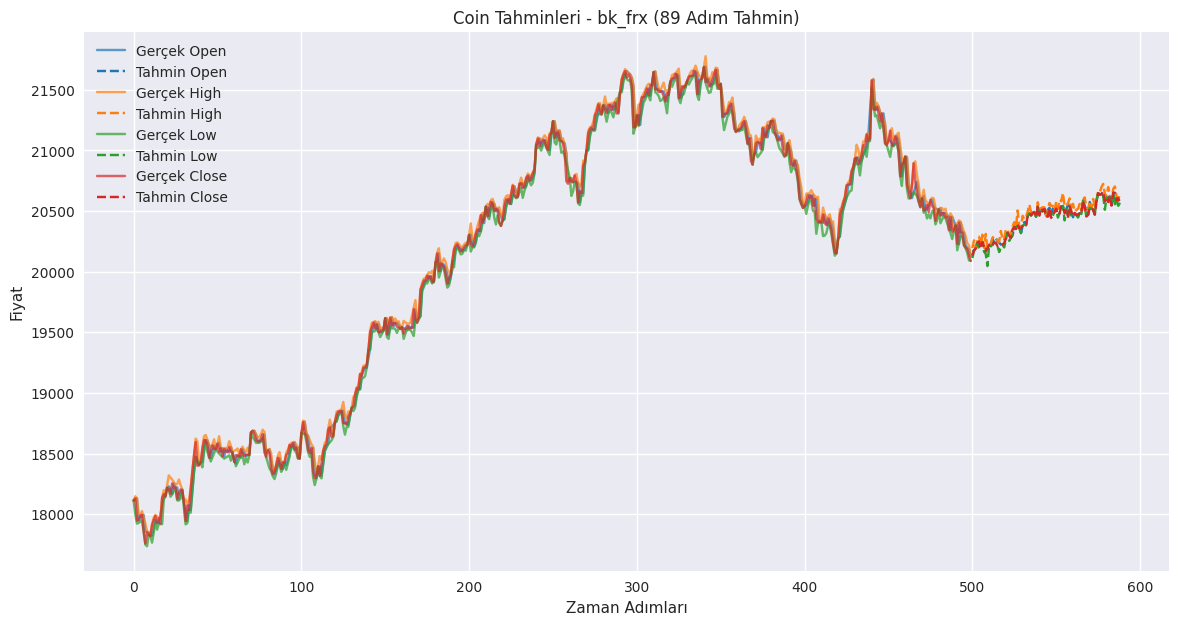

crp_ail İşleniyor: crp_ail_filled.xlsx
Tahmin Uzunluğu: 201
Lookback: 72
Çapraz Doğrulama Sayısı: 8

Eğitilen Fold 1...

Eğitilen Fold 2...

Eğitilen Fold 3...

Eğitilen Fold 4...

Eğitilen Fold 5...

Eğitilen Fold 6...

Eğitilen Fold 7...

Eğitilen Fold 8...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
crp_ail tahminleri kaydedildi: /kaggle/working/crp_ail_Tahminler.xlsx
Grafik dosyaya kaydedildi: /kaggle/working/crp_ail_Tahmin_Grafigi.png


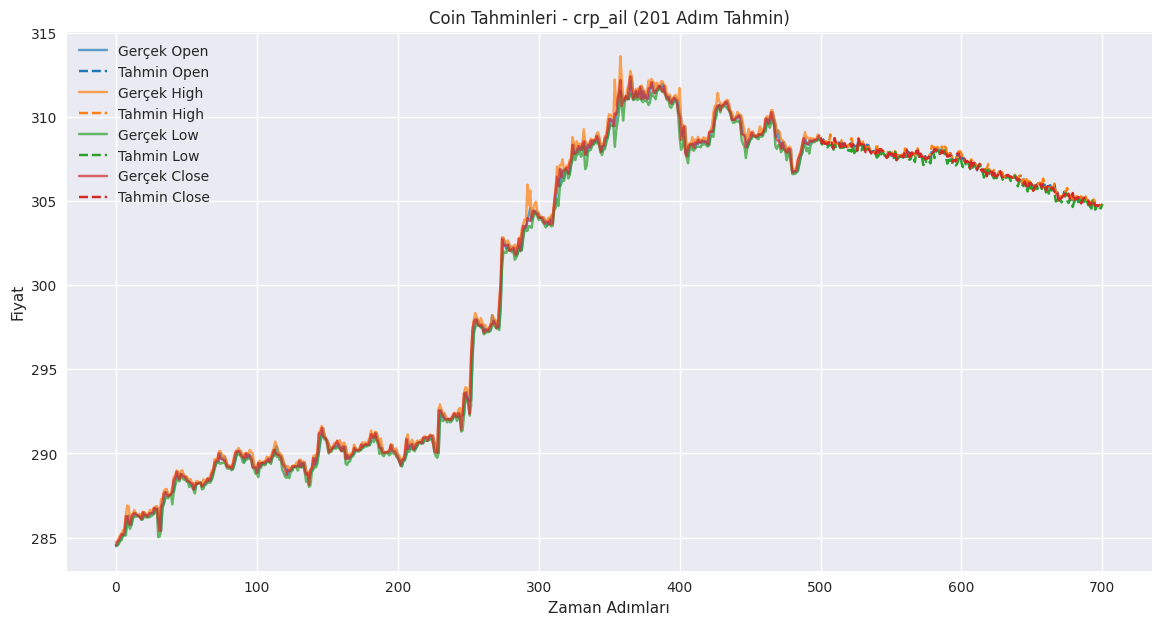

ail_frx İşleniyor: ail_frx_filled.xlsx
Tahmin Uzunluğu: 201
Lookback: 72
Çapraz Doğrulama Sayısı: 10

Eğitilen Fold 1...

Eğitilen Fold 2...

Eğitilen Fold 3...

Eğitilen Fold 4...

Eğitilen Fold 5...

Eğitilen Fold 6...

Eğitilen Fold 7...

Eğitilen Fold 8...

Eğitilen Fold 9...

Eğitilen Fold 10...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
ail_frx tahminleri kaydedildi: /kaggle/working/ail_frx_Tahminler.xlsx
Grafik dosyaya kaydedildi: /kaggle/working/ail_frx_Tahmin_Grafigi.png


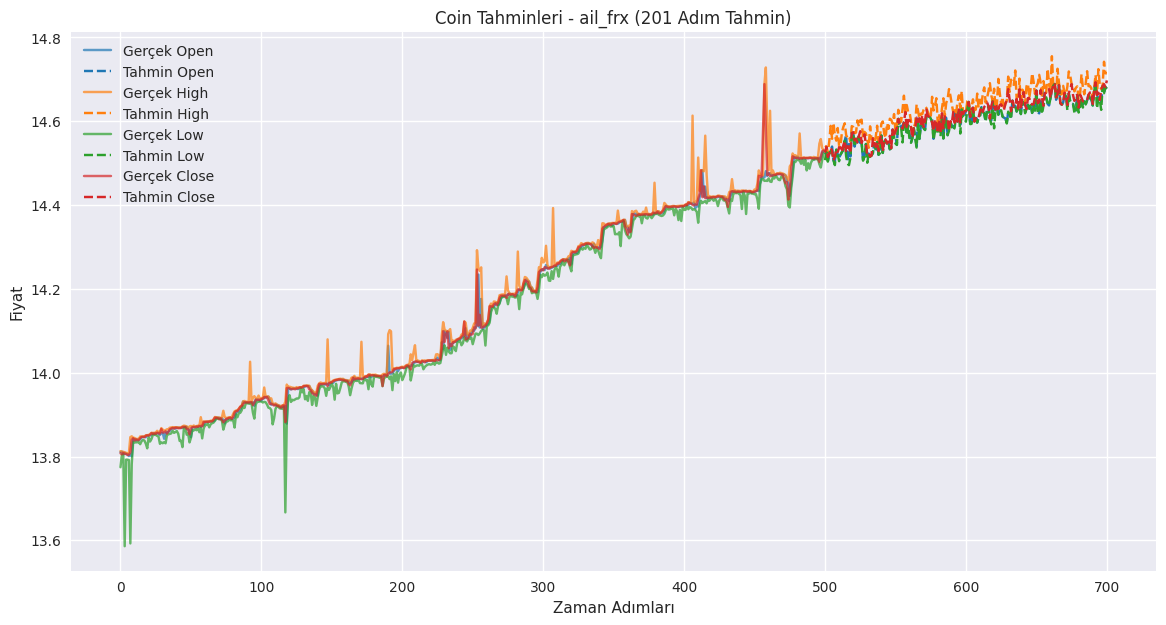

zzc_ail İşleniyor: zzc_ail_filled.xlsx
Tahmin Uzunluğu: 201
Lookback: 72
Çapraz Doğrulama Sayısı: 10

Eğitilen Fold 1...

Eğitilen Fold 2...

Eğitilen Fold 3...

Eğitilen Fold 4...

Eğitilen Fold 5...

Eğitilen Fold 6...

Eğitilen Fold 7...

Eğitilen Fold 8...

Eğitilen Fold 9...

Eğitilen Fold 10...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
zzc_ail tahminleri kaydedildi: /kaggle/working/zzc_ail_Tahminler.xlsx
Grafik dosyaya kaydedildi: /kaggle/working/zzc_ail_Tahmin_Grafigi.png


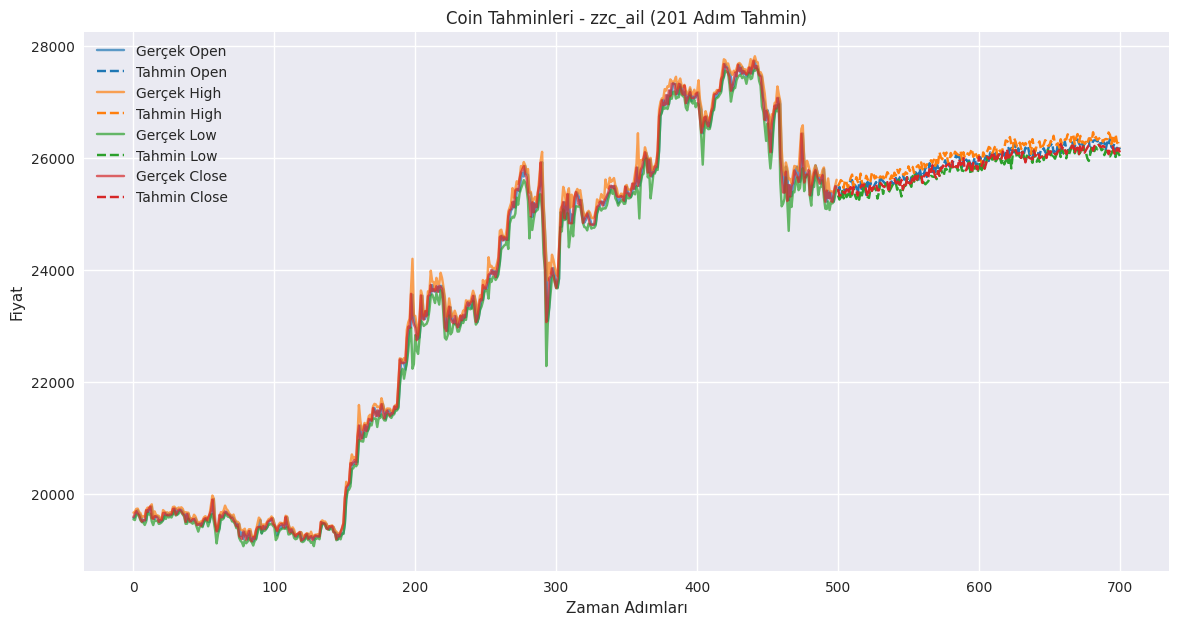


Tüm işlemler tamamlandı!


In [9]:
#---------------------------------------------------------------
#------------------------- ANA İŞ AKIŞI ------------------------
#---------------------------------------------------------------

if __name__ == "__main__":
    print(f"Toplam {COIN_SAYISI} Coin İşlenecek")
    
    all_predictions = []
    
    for idx, config in enumerate(COIN_CONFIG, 1):
            # Veri yükleme ve işleme alma
            print(f"{config['isim']} İşleniyor: {os.path.basename(config['dosya_yolu'])}")
            print(f"Tahmin Uzunluğu: {config['tahmin_uzunlugu']}")
            print(f"Lookback: {config['lookback']}")
            print(f"Çapraz Doğrulama Sayısı: {config['cross_validation_splits']}")
            
            df = load_and_preprocess_data(config['dosya_yolu'])
            df = add_technical_indicators(df)
            
            # Veri hazırlama
            X, y, scaler = prepare_data(df, lookback=config['lookback'], forecast_horizon=config['tahmin_uzunlugu'])
            
            # Model eğitimi
            model = create_lstm_model_with_attention((X.shape[1], X.shape[2]), config['tahmin_uzunlugu'])
            
            # Erken durdurma mekanizması
            early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)
            
            # Dinamik çapraz doğrulama mekanizması
            tscv = TimeSeriesSplit(n_splits=config['cross_validation_splits'])
            for fold, (train_index, test_index) in enumerate(tscv.split(X)):
                print(f"\nEğitilen Fold {fold+1}...")
                history = model.fit(X[train_index], y[train_index],
                                   epochs=35,
                                   batch_size=7,
                                   validation_data=(X[test_index], y[test_index]),
                                   callbacks=[early_stopping, reduce_lr],
                                   verbose=0) # İsteğe bağlı olarak '1' yapılarak terminalde model performansı izlenebilir
            # !Uyarı olarak verbose : 1 durumunda kernel şişme şişmekte her çalıştırmada clear cell outputs ile tekrar başlatmak gerekebilir
            
            # Tahmin yapma
            last_sequence = X[-1].reshape(1, *X.shape[1:])
            predictions = model.predict(last_sequence)
            
            # Ters ölçekleme
            data_min = scaler.data_min_[:4]
            data_max = scaler.data_max_[:4]
            predicted_values = predictions.reshape(-1, 4) * (data_max - data_min) + data_min
            
            # Adjusted fonksiyonu ile tahminleri son gerçek veriylere uyumlu hale getirme ve kaydetme
            adjusted_predictions = adjust_predictions(predicted_values, df)
            all_predictions.append(adjusted_predictions)
            save_predictions(adjusted_predictions, config['isim'])
            plot_results(df, adjusted_predictions, config['tahmin_uzunlugu'], config['isim'])  # Grafik çiz ve PNG olarak kaydet
    
    # Tüm tahminleri birleştirme
    combined_predictions = np.vstack(all_predictions)
    
    # Submission dosyası için ön hazırlık
    combined_df = pd.DataFrame(combined_predictions, columns=['open', 'high', 'low', 'close'])
    combined_df.insert(0, 'ID', range(1, len(combined_df) + 1))
    
    # date ve ID sütunlarını sample submission dosyasındakiler olarak kullanmak için dosyayı yükleme
    sample_submission = pd.read_csv("/kaggle/input/aiclub-datathon/sampleSubmission.csv")
    
    # Sample submission dosyasındaki hedef sütunlarımızın tahminlerini güncelleme
    sample_submission[['open', 'high', 'low', 'close']] = combined_df[['open', 'high', 'low', 'close']]
    
    # Nihai submission dosyasını kaydetme
    output_file = "/kaggle/working/submission.csv"
    sample_submission.to_csv(output_file, index=False)
    
    print("\nTüm işlemler tamamlandı!")